<a href="https://colab.research.google.com/github/yuaquintero/DeepLearning/blob/master/U4_05_%5BTALLER%5D_CNN_Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [0]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

## Check the following article on network architectures

- https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

In particular, 

- GlobalAveragePooling
- 1x1 convolutions
- Skip connections
- Networks modules:
    - **Inception**: multiple filter sizes on the same level (see [here](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202))
    - **Resnet**: learns residuals, gradients back propagate larger to earlier layers (see [here](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec))
    - **Xception**: depthwise separable convolutions (see [here](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec))
    

# Task: Use a Tensorflow hub model for image feature vector extraction

- browse this page, https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector
- select a TF2.0 model that provides feature vector
- load and resize the mini-cifar2 dataset to the image size required by the selected model (see [`skimage.transform.resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html?ref=driverlayer.com/web#skimage.transform.resize))
- apply the selected model layer to the resized mini-cifar2 dataset
- use any classical method from `scikit-learn` to create a classifier

In [39]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

File ‘mini_cifar_2.h5’ already there; not retrieving.



(0.0, 1.0)

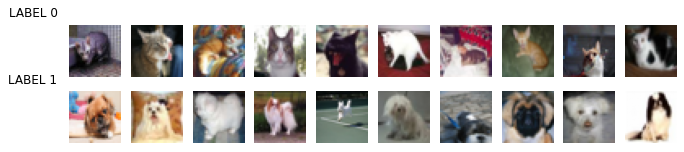

In [40]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
0    420
1    380
dtype: int64

distribution of test classes
1    117
0     83
dtype: int64


## Observe how we can apply a model to input data

- this example shows an untrained model
- you will have to do similarly with tfhub models

In [0]:
m = tf.keras.Sequential()
m.add(tf.keras.layers.InputLayer((32,32,3)))
m.add(tf.keras.layers.Flatten())
m.add(tf.keras.layers.Dense(20, activation="sigmoid"))


In [111]:
output = m(x_train.astype(np.float32)).numpy()
output.shape

(800, 20)

In [43]:
output

array([[0.7204134 , 0.54634327, 0.18745765, ..., 0.25782126, 0.5442875 ,
        0.74264836],
       [0.68588775, 0.6948303 , 0.20121172, ..., 0.47889107, 0.5871959 ,
        0.5944222 ],
       [0.64947635, 0.656932  , 0.24944171, ..., 0.43382126, 0.4786729 ,
        0.6131196 ],
       ...,
       [0.7786567 , 0.4646123 , 0.15451166, ..., 0.181676  , 0.59559757,
        0.7746318 ],
       [0.624236  , 0.5308234 , 0.37099338, ..., 0.4688601 , 0.56635845,
        0.5366842 ],
       [0.7131189 , 0.6625568 , 0.18801746, ..., 0.38398767, 0.7847064 ,
        0.6992675 ]], dtype=float32)

## Your solution here

In [0]:
import tensorflow_hub as hub
from skimage.transform import resize


In [0]:
num_classes=2

In [0]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_050_96/feature_vector/4",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, 96, 96, 3])  # Batch input shape.

In [95]:
m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  706224    
_________________________________________________________________
dense_4 (Dense)              multiple                  2562      
Total params: 708,786
Trainable params: 2,562
Non-trainable params: 706,224
_________________________________________________________________


In [0]:
x_cifar_r=np.zeros([1000, 96, 96, 3])

In [124]:
for i in range (x_cifar_r.shape[0]):
  x_cifar_r[i,:,:,:]=resize(x_cifar_r[i,0:,0:,0:],(96,96,3))
x_cifar_r.shape  

(1000, 96, 96, 3)

In [123]:
x_train_r, x_test_r, y_train, y_test = train_test_split(x_cifar_r, y_cifar, test_size=.2)
print(x_train_r.shape, y_train.shape, x_test_r.shape, y_test.shape)

(800, 96, 96, 3) (800,) (200, 96, 96, 3) (200,)


In [131]:
output = m(x_train_r.astype(np.float32))
output.shape

TensorShape([800, 2])